In [ ]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib
using Random: Xoshiro
using MLUtils: DataLoader

In [3]:
using PhasorNetworks

# Load the dataset

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
using Base: @kwdef

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(data_dir, 1:2)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
q_test, ylocal_test, pt_test = get_samples(data_dir, 3);

In [12]:
q |> size

(20, 13, 21, 99991)

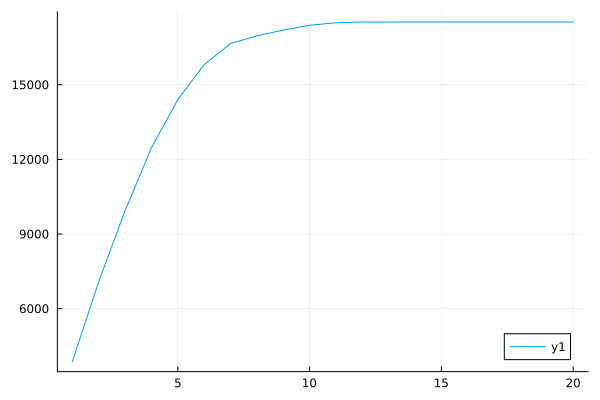

In [13]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

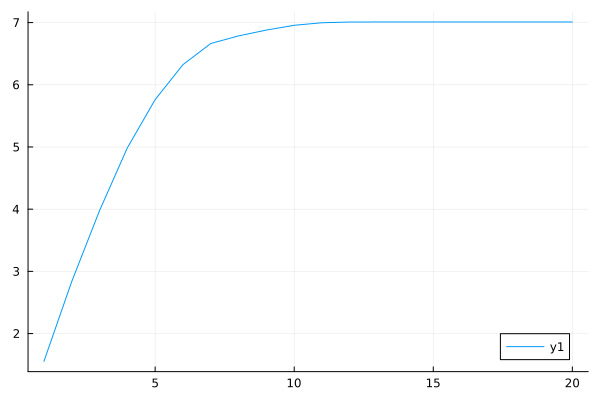

In [14]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(2,3)) |> vec)

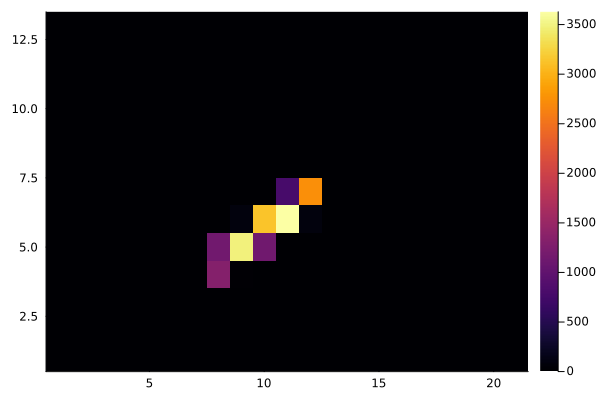

In [15]:
heatmap(q[12,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
x |> size

(20, 13, 21, 128)

In [23]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [24]:
function process_inputs(x, y_local)
    x = scale_charge(x)
    x = sum(x, dims=(1,3))
    n_batch = size(x, 4)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [25]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.00728   0.0       0.0          0.0       0.0002     0.0
  0.01548   3.89436   0.04744   0.02484      0.0       0.89496    0.02688
  4.53608  22.421     5.53156  10.3167       0.0      45.6419     8.18032
 13.0276   28.691    14.8939   42.2308       0.08     88.6978    38.3292
 18.1824   29.1889   21.668    39.5168   …  17.8984   40.6906    50.7078
 17.2391   11.8402   24.0816   74.3496      49.9682   -1.49488   27.1796
 12.8535   -0.58136   8.4348   -3.04328      0.58264   0.0       -1.61592
  7.73868   0.0      -0.44068  -0.00316     -0.19872   0.0        0.0
 -0.07108   0.0       0.0       0.0         -0.0002    0.0        0.0
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448      

In [26]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction(#28),
    layer_3 = PhasorDense((128, 14)),   # 1_920 parameters
    layer_4 = PhasorDense((3, 128)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [27]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.09775257 -0.033171576 … 0.044720445 -0.100962; 0.020251632 0.0070170956 … 0.08916796 -0.074335136; … ; 0.04797584 0.04434996 … 0.21813755 -0.054814056; -0.002902955 0.14405486 … 0.016870394 0.091666535], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias = ComplexF32[1

In [28]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([0.01652880900797455 -0.0032862464924963593 … 0.027729085046382648 0.051575945769566894; 0.1935191349744853 -0.10970797850244506 … -0.07015280669409078 -0.1027442013568622; -0.0386136501698181 0.012028034452065668 … 0.0960563517945893 0.13079205872441482], (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [29]:
y_naive |> size

(3, 128)

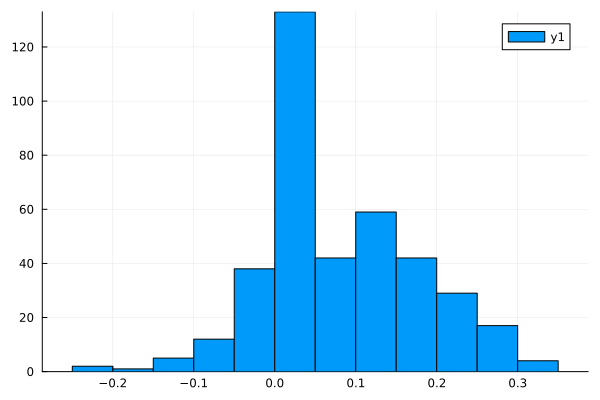

In [30]:
histogram(y_naive |> vec)

In [31]:
using Statistics: std, median, mean

In [32]:
using OneHotArrays

In [33]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [34]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [35]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [36]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [37]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.157669 seconds (582.55 k allocations: 46.785 MiB, 6.87% gc time, 99.24% compilation time)


(0.26988073231045157, (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [38]:
l0

0.26988073231045157

In [39]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [40]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 5)

[ Info: Constructing model and starting training


 39.800453 seconds (40.91 M allocations: 144.259 GiB, 15.94% gc time, 31.96% compilation time)


(Any[0.20984854418680132, 0.1984116888321737, 0.1898653194477286, 0.18531283616515104, 0.18251524889469795], (layer_1 = (scale = Float32[0.93863446, 0.96912265, 1.0012177, 0.8608649, 1.015118, 0.9721029, 1.1356807, 1.0628278, 1.0331489, 0.7480677, 0.80192, 0.73671615, 0.6995026, 0.36769712], bias = Float32[-0.049101908, -0.026879922, 0.084564015, 0.3154458, 0.14817795, 0.16539335, -0.021131175, 0.21631865, 0.00059167796, 0.027211621, -0.0696339, -0.1276511, -0.03949443, 0.12576732]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.07232265 -0.05799148 … 0.0848324 -0.18340395; 0.013749848 -0.015843358 … 0.11244063 -0.07750953; … ; 0.068780504 0.037097584 … 0.20825577 -0.0049899495; 0.009531122 0.12152398 … 0.031323165 0.05607146], bias = ComplexF32[0.99576545f0 - 0.012830419f0im, 1.0016888f0 + 0.004024343f0im, 1.0147921f0 - 0.036051296f0im, 1.0043403f0 + 0.001244103f0im, 1.0105592f0 + 0.03686318f0im, 0.9809494f0 + 0.048970144f0im, 0.9905791f0 - 0.02181f0im, 0.9971556f0 - 0.021749

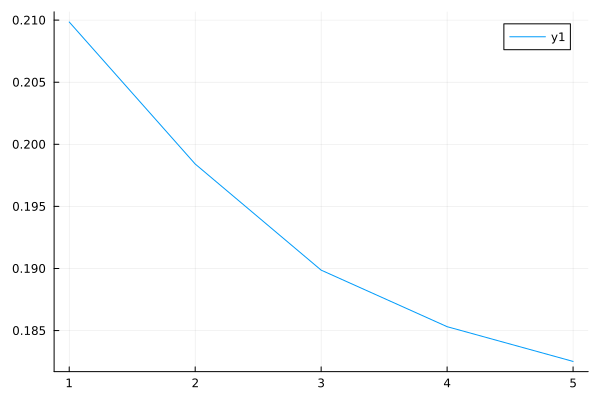

In [41]:
plot(loss_history)

In [42]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.1802723994496293

In [43]:
loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 95)

[ Info: Constructing model and starting training


(Any[0.1804335203551307, 0.17888900173445182, 0.17764142951589054, 0.17660306467632322, 0.17568994713505703, 0.17494154084702335, 0.1741873928533006, 0.17348917367761543, 0.17309308952087588, 0.17236670468917462  …  0.16147228295635985, 0.16146420021833363, 0.16147614117784237, 0.16147097374414093, 0.16131488215808293, 0.161280062230175, 0.16126727035122854, 0.1612051734724112, 0.1611522917972825, 0.16112090141265142], (layer_1 = (scale = Float32[0.45404676, 0.76948386, 0.97005975, 0.8345468, 1.035431, 0.78910655, 1.1388426, 1.197251, 1.0854445, 0.14965089, 0.20704237, 0.16085652, 0.09865069, 0.34632748], bias = Float32[-0.3068671, 0.038816772, 0.22971474, 0.5421788, 0.41109002, 0.5126615, 0.14228079, 0.40006015, 0.11159053, 0.09160295, -0.09863354, -0.21646282, -0.048005324, 0.29149792]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.09137273 -0.044615988 … 0.0021969182 -0.28765017; 0.018478138 -0.05282774 … 0.033001073 -0.03201427; … ; 0.15405017 0.00940712 … 0.22302276 -0.06

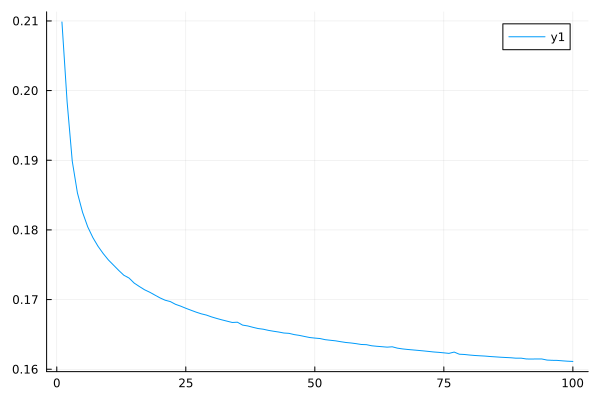

In [44]:
plot(vcat(loss_history, loss_history2))

In [45]:
pst = pst2

(layer_1 = (scale = Float32[0.45404676, 0.76948386, 0.97005975, 0.8345468, 1.035431, 0.78910655, 1.1388426, 1.197251, 1.0854445, 0.14965089, 0.20704237, 0.16085652, 0.09865069, 0.34632748], bias = Float32[-0.3068671, 0.038816772, 0.22971474, 0.5421788, 0.41109002, 0.5126615, 0.14228079, 0.40006015, 0.11159053, 0.09160295, -0.09863354, -0.21646282, -0.048005324, 0.29149792]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.09137273 -0.044615988 … 0.0021969182 -0.28765017; 0.018478138 -0.05282774 … 0.033001073 -0.03201427; … ; 0.15405017 0.00940712 … 0.22302276 -0.06005681; 0.05084392 0.063684195 … 0.0033747023 0.06966612], bias = ComplexF32[0.97111946f0 - 0.08028241f0im, 1.0271001f0 + 0.054615196f0im, 0.97093344f0 - 0.16210881f0im, 0.9746049f0 - 0.035798397f0im, 0.998775f0 - 0.025609225f0im, 0.97700316f0 + 0.029181285f0im, 0.9857252f0 - 0.078551054f0im, 0.94452244f0 - 0.23212205f0im, 1.0029535f0 + 0.010805318f0im, 1.0136987f0 + 0.12671357f0im  …  1.0308913f0 - 0.0049544615f0im, 0.

In [46]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [47]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.147503947953794, (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [48]:
loss_history[end]

0.18251524889469795

In [49]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([0.01944056493442488 0.01500885326239703 … 0.018356145372212297 0.01897730028320305; 0.5250367424070904 0.16162911573404368 … 0.191578443838056 0.1744744593593383; -0.005892004687044855 0.2666851918779819 … 0.27720251388064787 0.29477161778145883], (layer_1 = (running_mean = [0.5182423009455571, 0.6278795964072084, 3.648472243388443, 15.861443291403662, 39.669004742382114, 45.977552229162335, 34.641942681043396, 11.640081660936126, 1.4067330042548845, 0.24526209992802694, 0.18802580300197616, 0.08418600053450363, 0.0993031314082755, 0.2094285897770764], running_var = [40.899603734013134, 27.67855853087932, 132.3595513064586, 750.3003032910807, 2722.395062496112, 2487.166397521659, 2354.6690240326875, 705.3349909946818, 86.63589173414633, 17.293068252224234, 9.86353551373153, 2.283803227215314, 9.904646411140693, 19.978280087850898], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

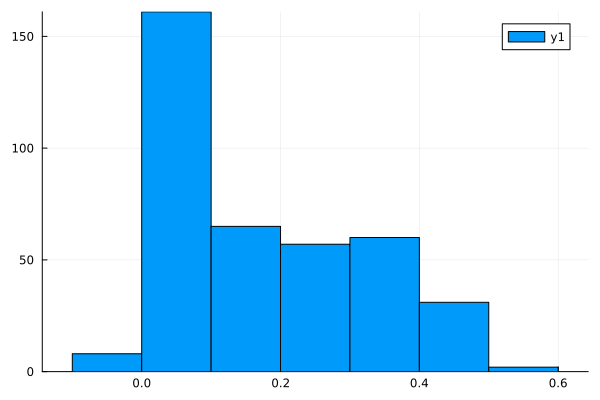

In [50]:
histogram(yt |> vec)

# Calculate the Test Loss

In [51]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [52]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [53]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, sttf)

([0.002661908839961652 0.02053483919350194 … 0.017482024324303035 0.013058923000888385; -0.022485401399778428 0.07645235107363882 … -0.007870700519790174 0.25664763353749587; 0.4494447067771434 0.49578366682413055 … 0.3805707519810376 0.2597859190789072], (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [54]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, sttf, 0.2)

7129

In [56]:
using LinearAlgebra: diag

In [57]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [58]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

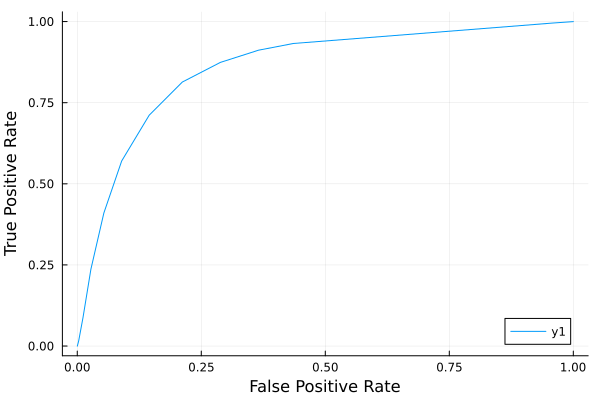

In [59]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [60]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8591495132720063, 1.2275329404927238e-8)